In [29]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [31]:
import optax

In [32]:
class MMD:

    def __init__(self, scales, space):
        gammas = 1 / (2 * (scales**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        self.scales = scales

    def k_expval(self, px, py):
        # Kernel expectation value
        return px @ self.K @ py

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

In [33]:
from functools import partial

class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py  # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

In [34]:
@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    return params, opt_state, loss_val, kl_div

## Multiple Distributions

In [53]:
def gaussian_pdf(x, mu, sigma):
    """Gaussian PDF"""
    var = sigma**2
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((x - mu) ** 2) / (2 * var))

def exponential_pdf(x, lam, shift):
    """Exponential PDF"""
    return lam * np.exp(-lam * (x - shift)) * (x >= shift)

def student_t_pdf(x, df, mu, scale):
    """Student-t PDF"""
    return t.pdf(x, df, loc=mu, scale=scale)

def stable_pdf(x, alpha, beta, mu, sigma):
    """Stable distribution PDF"""
    return levy_stable.pdf(x, alpha, beta, loc=mu, scale=sigma)

def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)

def mixture_pdf(x, params, distribution_type="gaussian"):
    """
    Mixture PDF for specified distribution type.
    
    Parameters:
        x : array-like, points where the PDF is evaluated
        params : list of tuples, parameters for each distribution
            Gaussian: (mu, sigma)
            Exponential: (lambda, shift)
            Student-t: (df, mu, scale)
            Stable: (alpha, beta, mu, sigma)
        distribution_type : str, distribution to use ("gaussian", "exponential", "student_t", "stable")
        
    Returns:
        Mixture PDF evaluated at x
    """
    x = np.array(x)
    pdf_funcs = {
        "gaussian": lambda x, p: gaussian_pdf(x, *p),
        "exponential": lambda x, p: exponential_pdf(x, *p),
        "student_t": lambda x, p: student_t_pdf(x, *p),
        "stable": lambda x, p: stable_pdf(x, *p),
    }
    
    if distribution_type not in pdf_funcs:
        raise ValueError(f"Unsupported distribution type: {distribution_type}")
    
    # Calculate PDFs for each component
    pdf_func = pdf_funcs[distribution_type]
    values = [pdf_func(x, p) for p in params]
    
    # Normalize weights and compute mixture
    values = np.array(values)
    mixture = np.sum(values / np.sum(values, axis=0, keepdims=True), axis=0)
    return mixture / np.sum(mixture)  # Normalize final mixture

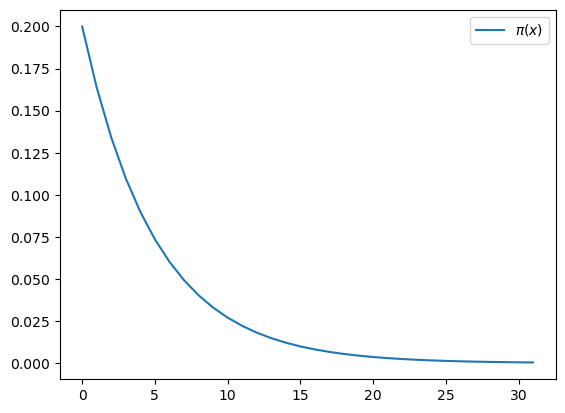

In [54]:
n_qubits = 5
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]
sigmas = [x_max / 8] * 2
data = exponential_pdf(x_input, 0.2, 0)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

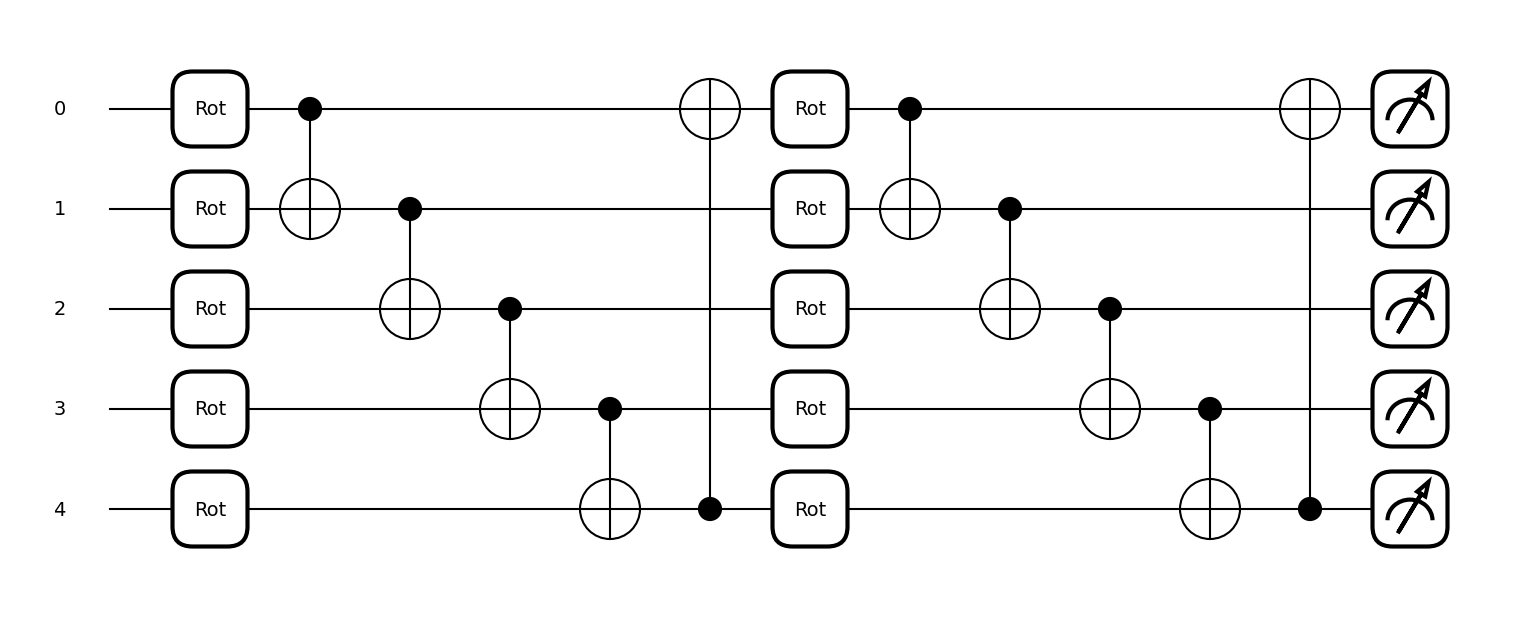

In [55]:
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 2
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [56]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.1061 KL-div: 2.4444
Step: 10 Loss: 0.0361 KL-div: 0.6369
Step: 20 Loss: 0.0074 KL-div: 0.2678
Step: 30 Loss: 0.0065 KL-div: 0.1527
Step: 40 Loss: 0.0058 KL-div: 0.1693
Step: 50 Loss: 0.0054 KL-div: 0.1541
Step: 60 Loss: 0.0053 KL-div: 0.1789
Step: 70 Loss: 0.0053 KL-div: 0.1957
Step: 80 Loss: 0.0053 KL-div: 0.1951
Step: 90 Loss: 0.0053 KL-div: 0.1992


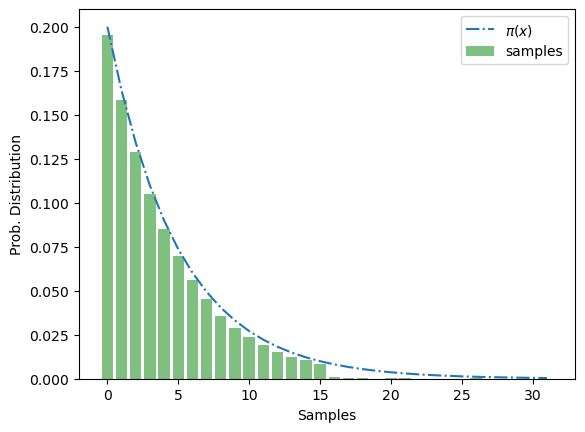

In [57]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()